In [14]:
import pandas as pd

data = pd.read_csv('./NFLX.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


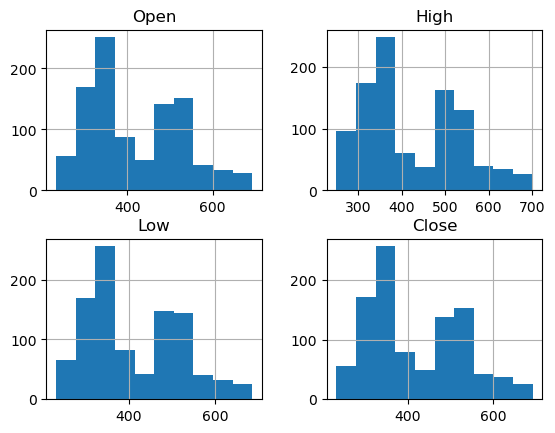

In [16]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]  # open, high, low
data_used['Close'] = data['Close']
hist = data_used.hist()
plt.show()

값 분포 값 넓게 형성되어 있어 정규화가 필요해 보임

In [17]:
import numpy as np
from torch.utils.data.dataset import Dataset


class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv('./NFLX.csv')

        # Normalize
        self.data = self.csv.iloc[:, 1:4].values
        # self.data = self.data / np.max(self.data)

        self.label = data['Close'].values
        # self.label = self.label / np.max(self.label)

    # 30일치씩 읽을 예정 때문에 전체 길이에서 - 30을 리턴
    def __len__(self):
        return len(self.data) - 30

    def __getitem__(self, item):
        data = self.data[item:item + 30]
        label = self.label[item + 30]

        return data, label

In [18]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        '''
        input size 입력 텐서의 특징 개수(개장가, 최고가, 최저가)
        hidden size hidden state의 벡터 크기?, 몇개의 아웃풋을 내보낼 것인지
        num layers 쌓을 rnn층 개수 의미, 너무 많이 쌓으면 기울기 폭발하므로 보통 3, 5를 사용
        batch first 배치 차원이 가장 앞으로 배치
        '''
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)

        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)

        x = torch.reshape(x, (x.shape[0], -1))

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = torch.flatten(x)

        return x

In [19]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model = RNN().to(device)
dataset = Netflix()

loader = DataLoader(dataset, batch_size=32)

optim = Adam(params=model.parameters(), lr=0.0001)

for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()

        h0 = torch.zeros(5, data.shape[0], 8).to(device)

        pred = model(data.type(torch.FloatTensor).to(device), h0)

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optim.step()

        iterator.set_description(f'epoch: {epoch} loss: {loss.item()}')

torch.save(model.state_dict(), './rnn.pth')

epoch: 199 loss: 5119.2041015625: 100%|██████████| 31/31 [00:05<00:00,  6.16it/s]  


In [20]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)

preds = []
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load('./rnn.pth', map_location=device))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)

        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))

        total_loss += loss / len(loader)

In [21]:
total_loss.item()  # 정규화 제거시 학습이 안됨

11539.416015625

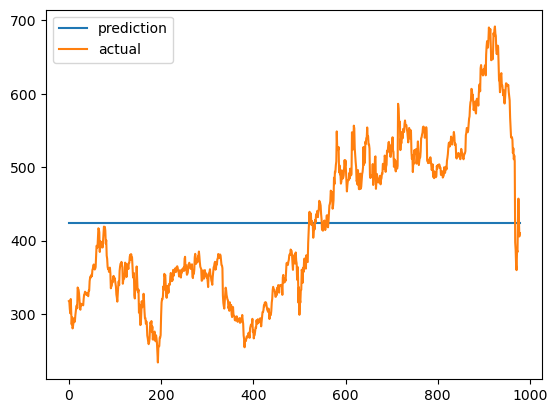

In [22]:
plt.plot(preds, label='prediction')
plt.plot(dataset.label[30:], label='actual')
plt.legend()
plt.show()